In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import numpy as np
import sklearn
from sklearn.metrics import roc_auc_score, fbeta_score, precision_score, recall_score
import catboost

SEED = 42
%matplotlib inline
sns.set(style='whitegrid',
        rc={'figure.figsize': (14, 6)})

In [2]:
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('sklearn', sklearn.__version__)
print('catboost', catboost.__version__)

pandas 1.3.0
numpy 1.20.3
sklearn 0.24.2
catboost 0.24.2


In [3]:
curr_dir = os.getcwd()
data_dir = os.path.join(curr_dir, 'data')
cases_dir = os.path.join(curr_dir, 'data/court_cases_sample/success')

In [4]:
accounts_sample = pd.read_csv(os.path.join(data_dir, 'df_accounts_sample.csv'), index_col=0)
bankruptcies_sample = pd.read_csv(os.path.join(data_dir, 'df_bankruptcies_sample.csv'), index_col=0)

In [5]:
accounts_sample.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,2465002653,2012,0.0,113756,122240,384
1,3505003270,2012,21461.0,20211,81132,384
2,3517003250,2012,0.0,0,48063,384
3,5501078737,2012,0.0,288763,419522,384
4,6140019517,2012,0.0,0,11089,384


In [6]:
accounts_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   inn                                 1035 non-null   int64  
 1   year                                1035 non-null   int64  
 2   long_term_liabilities_fiscal_year   960 non-null    float64
 3   short_term_liabilities_fiscal_year  1035 non-null   int64  
 4   balance_assets_fiscal_year          1035 non-null   int64  
 5   okei                                1035 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 56.6 KB


In [7]:
def okei(line):
    """
    принимает на вход строку таблицы accounts_sample, возвращает все финансовые показатели, 
    умноженные на коэфф в зависимости от значения okei.
    """
    mult = {384: 1e3, 385: 1e6}
    if line.okei in mult:
        coef = mult[line.okei]
        line.long_term_liabilities_fiscal_year *= coef
        line.short_term_liabilities_fiscal_year *= coef
        line.balance_assets_fiscal_year *= coef
        
    return line

In [8]:
# умножим все финансовые показатели на соответствующий им коэфф и удалим столбец okei
accounts_sample = accounts_sample.apply(okei, axis=1)
accounts_sample.drop('okei', axis=1, inplace=True)

In [9]:
bankruptcies_sample.head()

,bankrupt_id,bancrupt_year,inn
0,79546,2015,5620006322
1,76594,2015,2111008200
2,94301,2016,5414100369
3,93799,2019,2347009476
4,199671,2018,7224008489


In [10]:
bankruptcies_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   bankrupt_id    106 non-null    int64
 1   bancrupt_year  106 non-null    int64
 2   inn            106 non-null    int64
dtypes: int64(3)
memory usage: 3.3 KB


In [11]:
# столбец bankrupt_id нам не нужен
bankruptcies_sample.drop('bankrupt_id', axis=1, inplace=True)

In [12]:
# создадим новый столбец 'bankrupt' в таблице accounts_sample, это будет наш таргет
# заполним единицами те объекты, ИНН и год которых соответствует банкротству фирмы
for year, inn in bankruptcies_sample.values:
    idx = accounts_sample[(accounts_sample.inn == inn) & (accounts_sample.year == year)].index
    accounts_sample.loc[idx, 'bankrupt'] = 1
# значения для остальных объектов заполним нулями
accounts_sample.bankrupt.fillna(0, inplace=True)
# accounts_sample.bankrupt = accounts_sample.bankrupt.astype('int')

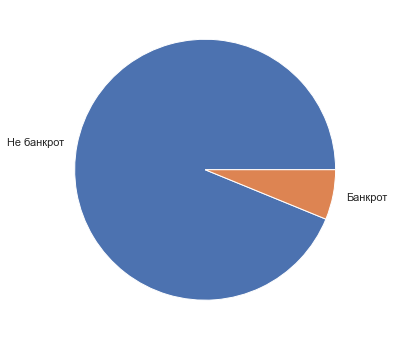

In [13]:
plt.pie(accounts_sample.bankrupt.value_counts(), labels=['Не банкрот', 'Банкрот']);

In [14]:
print('Доля банкротств:', f'{100 * accounts_sample.bankrupt.value_counts()[1] / len(accounts_sample):.2f}%')

Доля банкротств: 6.18%


Данные очень не сбалансированны, для даунсемплинга данных мало, можно будет попробовать оверсемплинг.

In [15]:
accounts_sample.long_term_liabilities_fiscal_year.value_counts()

0.0            622
104013000.0      8
4000.0           6
102000.0         6
6000000.0        6
              ... 
36450000.0       1
98009000.0       1
33350000.0       1
3211000.0        1
17000.0          1
Name: long_term_liabilities_fiscal_year, Length: 255, dtype: int64

In [16]:
print('Доля банкротств среди фирм, где известна long_term_liabilities_fiscal_year:', 
      f'{accounts_sample.bankrupt[accounts_sample.long_term_liabilities_fiscal_year.notna()].mean():.2f}')

print('Доля банкротств среди фирм, где НЕ известна long_term_liabilities_fiscal_year:', 
      f'{accounts_sample.bankrupt[accounts_sample.long_term_liabilities_fiscal_year.isna()].mean():.2f}')

print('Доля банкротств среди фирм, long_term_liabilities_fiscal_year равна 0:', 
      f'{accounts_sample.bankrupt[accounts_sample.long_term_liabilities_fiscal_year == 0].mean():.2f}')

Доля банкротств среди фирм, где известна long_term_liabilities_fiscal_year: 0.06
Доля банкротств среди фирм, где НЕ известна long_term_liabilities_fiscal_year: 0.08
Доля банкротств среди фирм, long_term_liabilities_fiscal_year равна 0: 0.06


Доля банкротств среди фирм, где данные NaN чуть выше, чем среди известных или среди тех, где значение = 0. 
Это возможное место для экспериментов, но в начале мне кажется, что заменить пропущенные данные на 0 наиболее разумное решение. 0 - встречается чаще всего среди значений, плюс NaN в данной ситуации часто может означать как раз ноль.


In [17]:
accounts_sample.long_term_liabilities_fiscal_year.fillna(0, inplace=True)

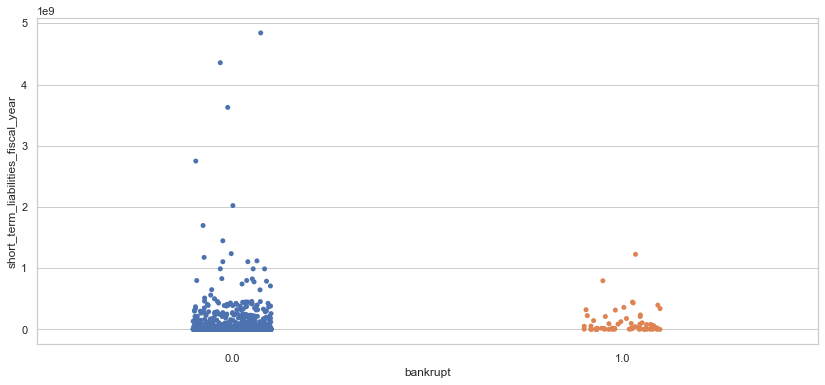

In [18]:
sns.stripplot(x=accounts_sample.bankrupt, y=accounts_sample.short_term_liabilities_fiscal_year);

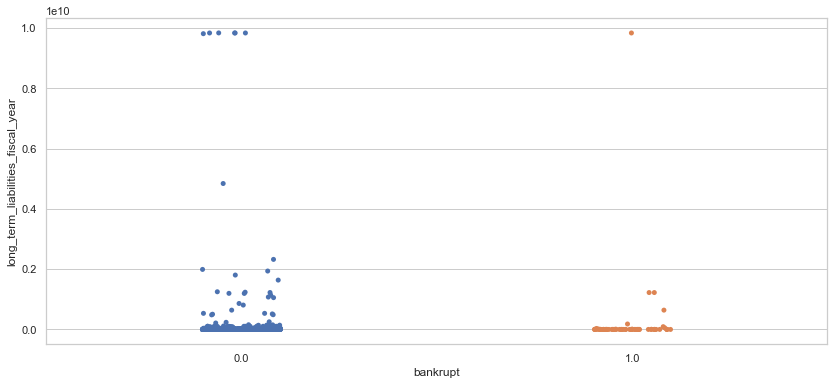

In [19]:
sns.stripplot(x=accounts_sample.bankrupt, y=accounts_sample.long_term_liabilities_fiscal_year);

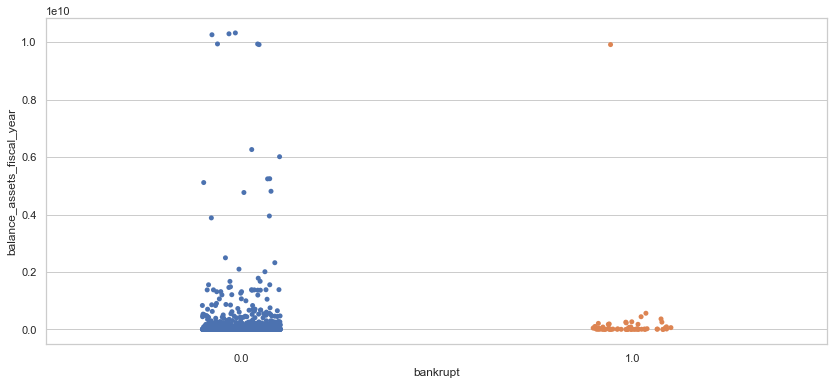

In [20]:
sns.stripplot(x=accounts_sample.bankrupt, y=accounts_sample.balance_assets_fiscal_year);

Значения, равные нулю преобладают во всех трех признаках и среди банкротов и не банкротов. Но среди долгосрочных обязательств и активах на начало года у банкротов практически все значения - нули.

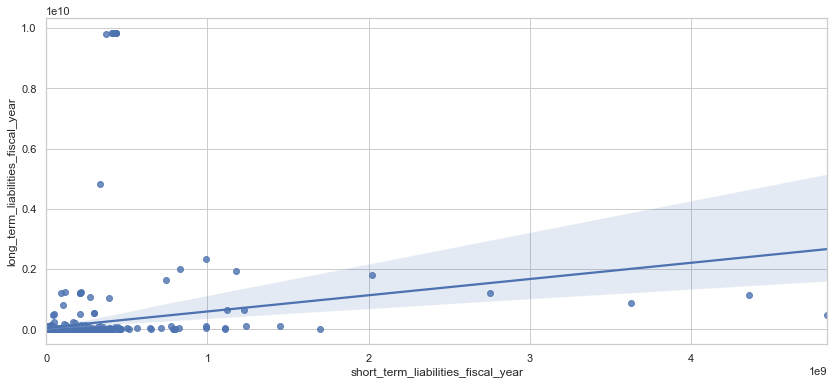

In [21]:
sns.regplot(x=accounts_sample.short_term_liabilities_fiscal_year, 
            y=accounts_sample.long_term_liabilities_fiscal_year,
           );

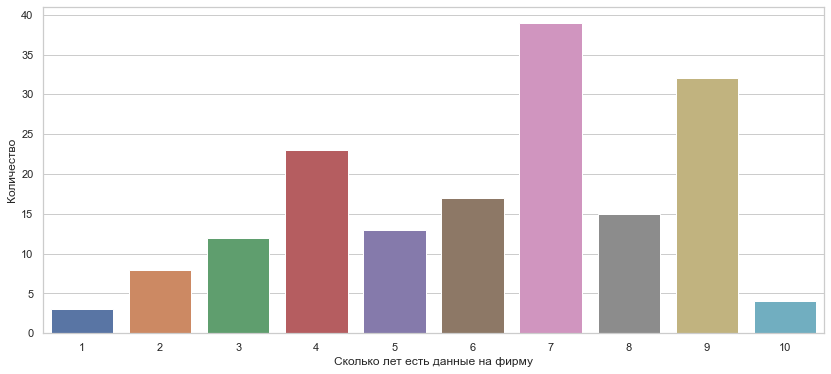

In [22]:
sns.countplot(x=accounts_sample.year.groupby(accounts_sample.inn).count().values).set(
    xlabel='Сколько лет есть данные на фирму', ylabel='Количество');

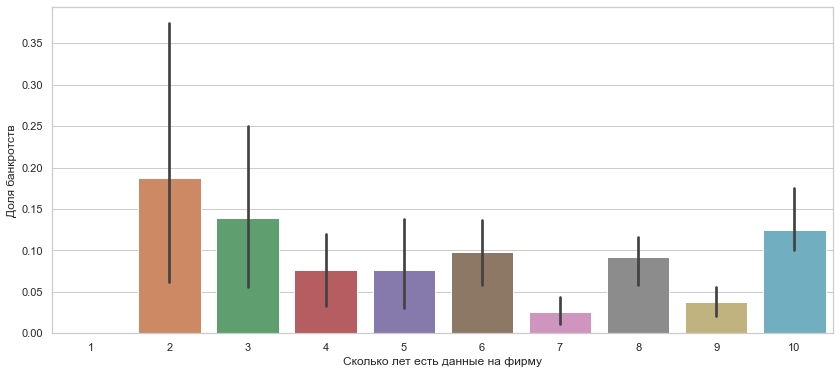

In [23]:
sns.barplot(x=accounts_sample.year.groupby(accounts_sample.inn).count(),
            y=accounts_sample.bankrupt.groupby(accounts_sample.inn).mean()
           ).set(ylabel='Доля банкротств', xlabel='Сколько лет есть данные на фирму');

Соберем из cases_dir файлов с судебными процессами датафрейм, каждый объект будет иметь вид:
    
    ИНН, год процесса, результат процесса, сумма иска, валюта, тип дела

In [25]:
columns = ['inn', 'year', 'result', 'money', 'currency', 'case_type']
df_cases = pd.DataFrame(columns=columns)

for file in os.listdir(cases_dir):
    if file.endswith('.pkl'):
        with open(os.path.join(cases_dir, file) , 'rb') as f:
            dict = pkl.load(f)
        inn = dict['inn']
        
        for case in dict['cases_list']:
            year = case['caseDate'][:4]
            result = case['resultType']
            money = case['sum']
            currency = case['currency']
            for side in case['case_sides']:
                if str(inn) in side['INN']:
                    case_type = side['type']

            line = pd.DataFrame([[inn, year, result, money, currency, case_type]], columns=columns)
            df_cases = pd.concat([df_cases, line], axis=0)

In [26]:
df_cases[['inn', 'year', 'case_type']] = df_cases[['inn', 'year', 'case_type']].astype('int64')
df_cases.set_index(np.arange(len(df_cases)), inplace=True)

In [27]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8042 entries, 0 to 8041
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inn        8042 non-null   int64  
 1   year       8042 non-null   int64  
 2   result     8042 non-null   object 
 3   money      8042 non-null   float64
 4   currency   8042 non-null   object 
 5   case_type  8042 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 439.8+ KB


In [28]:
df_cases.head()

,inn,year,result,money,currency,case_type
0,1001003743,2020,Частично выиграно,1459183.00,643,0
1,1001003743,2014,Не удалось определить,79200.00,643,0
2,1001003743,2010,Выиграно,0.00,643,0
3,1001003743,2010,Не удалось определить,0.00,643,0
4,1020010136,2020,Не удалось определить,17302.73,643,1


In [29]:
df_cases.currency.value_counts()

643    8042
Name: currency, dtype: int64

In [30]:
# Все иски в рублях, можно дропнуть колонку.df_cases
df_cases.drop('currency', axis=1, inplace=True)

In [31]:
df_cases.result.value_counts()

Не удалось определить                                          4335
Проиграно                                                      1417
Выиграно                                                        911
Частично проиграно                                              264
Не выиграно                                                     244
Частично выиграно                                               233
Не проиграно                                                    229
Иск полностью удовлетворен                                      200
В иске отказано полностью                                       122
Иск частично удовлетворен                                        40
Утверждено мировое соглашение                                    25
Иск не рассмотрен                                                16
Прекращено производство по делу                                   3
Иск полностью удовлетворен, встречный частично удовлетворен       1
Иск частично удовлетворен, встречный не удовлетв

In [32]:
def result_process(line):
    """
    Принимает на вход текстовое описание результата процесса,
    возвращает 1 в случае полного\частичного удовлетворения,
    0 в обратном случае, -1 в случае, когда результат неизвестен
    """
    unkn = {'Не удалось определить', 'Иск не рассмотрен', 'Прекращено производство по делу', 'Утверждено мировое соглашение'}
    loose = {'Проиграно', 'Частично проиграно', 'Не выиграно', 'В иске отказано полностью',}
    win = {'Выиграно', 'Частично выиграно', 'Не проиграно', 'Иск полностью удовлетворен', 'Иск частично удовлетворен', 'В иске отказано частично',
          'Иск полностью удовлетворен, встречный частично удовлетворен', 'Иск частично удовлетворен, встречный не удовлетворен'}
    
    if line in unkn:
        return -1
    if line in loose:
        return 0
    if line in win:
        return 1
    
    return 0

In [33]:
df_cases.result = df_cases.result.apply(result_process)

In [34]:
df_cases.head()

,inn,year,result,money,case_type
0,1001003743,2020,1,1459183.00,0
1,1001003743,2014,-1,79200.00,0
2,1001003743,2010,1,0.00,0
3,1001003743,2010,-1,0.00,0
4,1020010136,2020,-1,17302.73,1


Создадим новые признаки, для каждого ИНН в каждом году:

    case_0_count - количество судебных дел, где ИНН является истцом
    
    case_1_count - количество судебных дел, где ИНН является ответчиком
    
    case_0_result_1_count - case_0 где иск удовлетворен
    
    case_0_result_0_count - case_0 где не удовлетворен
    
    case_1_result_1_count - case_1 удовл
    
    case_1_result_0_count - case_1 не удовл

In [35]:
tmp = df_cases.groupby(['inn', 'year'])['case_type'].value_counts()

for (inn, year, case_type), count in zip(tmp.index, tmp.values):
    if case_type in (0, 1):
        idx = accounts_sample[(accounts_sample.inn == inn) & (accounts_sample.year == year)].index
        if idx is not None:
            accounts_sample.loc[idx, 'case_' + str(case_type)+'_count'] = count

In [36]:
tmp = df_cases.groupby(['inn', 'year', 'case_type'])['result'].value_counts()
for (inn, year, case_type, case_result), count in zip(tmp.index, tmp.values):
    if case_type in (0, 1) and case_result in (0, 1):
        idx = accounts_sample[(accounts_sample.inn == inn) & (accounts_sample.year == year)].index
        if idx is not None:
            accounts_sample.loc[idx, 'case_'+str(case_type)+'_result_'+str(case_result)+'_count'] = count

In [37]:
accounts_sample.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,bankrupt,case_0_count,case_1_count,case_0_result_1_count,case_0_result_0_count,case_1_result_0_count,case_1_result_1_count
0,2.465003e+09,2012.0,0.0,113756000.0,122240000.0,0.0,3.0,1.0,NaN,1.0,1.0,NaN
1,3.505003e+09,2012.0,21461000.0,20211000.0,81132000.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN
2,3.517003e+09,2012.0,0.0,0.0,48063000.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN
3,5.501079e+09,2012.0,0.0,288763000.0,419522000.0,0.0,6.0,1.0,1.0,3.0,NaN,1.0
4,6.140020e+09,2012.0,0.0,0.0,11089000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# заполним нулями все остальные значения
accounts_sample.fillna(0, inplace=True)

In [39]:
accounts_sample.year = accounts_sample.year.astype('int64').astype('str')
accounts_sample.inn = accounts_sample.inn.astype('int64').astype('str')

In [40]:
accounts_sample

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,bankrupt,case_0_count,case_1_count,case_0_result_1_count,case_0_result_0_count,case_1_result_0_count,case_1_result_1_count
0,2465002653,2012,0.0,113756000.0,122240000.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0
1,3505003270,2012,21461000.0,20211000.0,81132000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3517003250,2012,0.0,0.0,48063000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,5501078737,2012,0.0,288763000.0,419522000.0,0.0,6.0,1.0,1.0,3.0,0.0,1.0
4,6140019517,2012,0.0,0.0,11089000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1030,7842353970,2020,0.0,2548000.0,16411000.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1031,8908001998,2019,0.0,8636000.0,130731000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1032,8908001998,2020,0.0,14318000.0,128891000.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
1033,9102060446,2019,6000000.0,229769000.0,308868000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
accounts_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1035 entries, 0 to 1034
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   inn                                 1035 non-null   object 
 1   year                                1035 non-null   object 
 2   long_term_liabilities_fiscal_year   1035 non-null   float64
 3   short_term_liabilities_fiscal_year  1035 non-null   float64
 4   balance_assets_fiscal_year          1035 non-null   float64
 5   bankrupt                            1035 non-null   float64
 6   case_0_count                        1035 non-null   float64
 7   case_1_count                        1035 non-null   float64
 8   case_0_result_1_count               1035 non-null   float64
 9   case_0_result_0_count               1035 non-null   float64
 10  case_1_result_0_count               1035 non-null   float64
 11  case_1_result_1_count               1035 no

Разобьем выборку на тренировочную 0.8 и валидационную 0.2.

Т.к. наши данные идут по годам, чтобы не учиться на "данных из будущего", упорядочим данные по годам и в качестве валидационных данных возьмем более поздние года.


In [42]:
# пробовал делать oversampling, он не зашел
# split_idx = 4 * len(accounts_sample) // 5
# oversample = 3

# X_train = accounts_sample.sort_values(by=['year'])[:split_idx]
# for i in range(oversample):
#     X_train = pd.concat([X_train, X_train[X_train.bankrupt == 1]], axis=0)
    
# y_train = X_train['bankrupt']
# X_train.drop('bankrupt', axis=1, inplace=True)

In [43]:
split_idx = 4 * len(accounts_sample) // 5

X_train = accounts_sample.sort_values(by=['year'])[:split_idx]
y_train = X_train['bankrupt']
X_train.drop('bankrupt', axis=1, inplace=True)

X_val = accounts_sample.sort_values(by=['year'])[split_idx:]
y_val = X_val['bankrupt']
X_val.drop('bankrupt', axis=1, inplace=True)

В качестве модели возьмет catboost. На моей практике, градиентный бустинг лучше других моделей заходит в подобных задачах.

Т.к. данные очень не сбалансированные, выберем ROC-AUC как основную метрику, но так же обратим внимание как на f1-score в целом, так и на precision и recall по отдельности.

In [44]:
cat_cols = ['year', 'inn']
cat = catboost.CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC', random_seed=SEED)

In [45]:
cat.fit(X_train, y_train, silent=True)

In [46]:
preds = cat.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, preds)

0.815108759553204

Подбор параметров. Напишем свой гридсерч, чтобы учиться и валидироваться на отсортированных по годам данных.

In [47]:
learning_rate = [0.1, 0.5, 1]
depth = [3, 6, 9]
n_est = [40, 100, 200]
l2_leaf_reg = [3, 6]

cat_cols = ['year', 'inn']

In [48]:
roc = 0
best_f1 = 0
for lr in learning_rate:
    for d in depth:
        for n in n_est:
            for l2 in l2_leaf_reg:
                cat = catboost.CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC', random_seed=SEED)
                params_grid = {
                    'learning_rate': lr,
                    'depth': d,
                    'n_estimators': n,
                    'l2_leaf_reg': l2,
                }
                cat.set_params(**params_grid)
                cat.fit(X_train, y_train, silent=True)
                preds = cat.predict_proba(X_val)[:, 1]
                curr_roc = roc_auc_score(y_val, preds)
                print('ROC-AUC =', params_grid, curr_roc)
                if curr_roc > roc:
                    roc = curr_roc
                    params = params_grid

ROC-AUC = {'learning_rate': 0.1, 'depth': 3, 'n_estimators': 40, 'l2_leaf_reg': 3} 0.8835978835978837
ROC-AUC = {'learning_rate': 0.1, 'depth': 3, 'n_estimators': 40, 'l2_leaf_reg': 6} 0.8571428571428572
ROC-AUC = {'learning_rate': 0.1, 'depth': 3, 'n_estimators': 100, 'l2_leaf_reg': 3} 0.8300999412110524
ROC-AUC = {'learning_rate': 0.1, 'depth': 3, 'n_estimators': 100, 'l2_leaf_reg': 6} 0.8527336860670194
ROC-AUC = {'learning_rate': 0.1, 'depth': 3, 'n_estimators': 200, 'l2_leaf_reg': 3} 0.8600823045267489
ROC-AUC = {'learning_rate': 0.1, 'depth': 3, 'n_estimators': 200, 'l2_leaf_reg': 6} 0.8177542621987066
ROC-AUC = {'learning_rate': 0.1, 'depth': 6, 'n_estimators': 40, 'l2_leaf_reg': 3} 0.8731628453850676
ROC-AUC = {'learning_rate': 0.1, 'depth': 6, 'n_estimators': 40, 'l2_leaf_reg': 6} 0.8818342151675485
ROC-AUC = {'learning_rate': 0.1, 'depth': 6, 'n_estimators': 100, 'l2_leaf_reg': 3} 0.871546149323927
ROC-AUC = {'learning_rate': 0.1, 'depth': 6, 'n_estimators': 100, 'l2_leaf_reg

In [49]:
print('best_params = ', params)
print('best_roc = ', roc)

best_params =  {'learning_rate': 0.1, 'depth': 3, 'n_estimators': 40, 'l2_leaf_reg': 3}
best_roc =  0.8835978835978837


Потом я еще в ручную поигрался с параметрами, пытаясь максимизировать так же и f1, чуть потеряв в ROC-AUC. 

В итоге получились следующие параметры:

In [50]:
best_params = {'learning_rate': 0.1, 'depth': 9, 'n_estimators': 40, 'l2_leaf_reg': 6}

In [51]:
cat = catboost.CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC', random_seed=SEED)
cat.set_params(**best_params)

In [52]:
cat.fit(X_train, y_train, silent=True)

In [53]:
preds = cat.predict_proba(X_val)[:, 1]
print('ROC-AUC = ', f'{roc_auc_score(y_val, preds):.3f}')

ROC-AUC =  0.879


Подберем отсечку того, когда считать фирму банкротом, которая максимизирует f1. Я считаю, что в нашей задаче recall важнее, поэтому возьму fbeta_score, которая в случае бетта больше 1, делает precision менее важным.

In [54]:
best_f1 = 0
threshold = 0
for th in np.linspace(0, 1, 100):
    curr_score = fbeta_score(y_val, preds>th, beta=2)
    curr_prec = precision_score(y_val, preds>th, zero_division=0)
    curr_recall = recall_score(y_val, preds>th)

    if curr_score > best_f1:
        best_f1 = curr_score
        threshold = th

print('threshold = ', f'{threshold:.2f}')
print('f1 = ', f'{best_f1:.2f}')
print('precision', f'{precision_score(y_val, preds>threshold, zero_division=0):.2f}')
print('recall', f'{recall_score(y_val, preds>threshold):.2f}')

threshold =  0.16
f1 =  0.61
precision 0.25
recall 0.94


Максимальный f1 достигается при отсечке вероятности банкротства в 16%. При такой отсечке и betta=2 precision достаточно низкий, тогда как recall высокий. 

Отсечкой и betta можно управлять в зависимости от более консервативной, либо рискованной финаносовой политике. 

Как один из вариантов оценки нашей доходности:

    p_bankrupcy - вероятность банкротства
    EV - ожидаемый доход
    loss - потери в случае банкротства
    Summary Value - общий доход

Summary Value = (1 - p_bankrupcy) * EV - p_bankrupcy * loss

Посмотрим, какие вероятности возвращает наша модель на случаи, когда фирмы стали банкротами.

In [55]:
y_val.reset_index(drop=True)
preds[y_val==1]

array([0.12434205, 0.23989192, 0.1655665 , 0.21127809, 0.18779459,
       0.1703467 , 0.19820204, 0.16950643, 0.16646322, 0.19588644,
       0.22684271, 0.18588671, 0.23989192, 0.26523815, 0.20458707,
       0.22109771, 0.2014841 , 0.20058744])

Вероятности довольно низкие, максимальная вероятность 26%. 
Мне кажется, что с тем набором данных, да и в целом в этой задаче сложно ожидать более уверенные предсказания, т.к если бы вероятность банкротства фирмы была например 80%, то скорее всего она бы уже до этого разорилась, тк инвесторы заранее начали бы выводить свои деньги, когда вероятность банкротства была ниже.

Именно поэтому в данном кейсе надо очень аккуратно работать с отсечкой в зависимости от того, что мы хотим повышать - precision или recall.


Возможные действия для дальнейшего улучшения модели:

    - получить больше информации из файлов судебных заседаний. Как вариант - сделать признак общая сумма открытых исков на начало года.
    
    - найти больше финансовых показателей на компании